# Predict KBO 2020


## KBO 정규 리그 우승팀 및 포스트 시즌 진출 팀 예측

최근 10년간의 정규리그 성적을 바탕으로 2020 시즌 우승팀과 플레이오프 진출팀을 예측하는

머신러닝 모델을 만들어 보자.

### Import necessary libraries


In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

%matplotlib inline
mpl.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-colorblind')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

### Data Set

분석 자료는 한국야구위원회 공식 홈페이지 기록실에서 추출한 팀기록을 사용하였다.  

링크 (https://www.koreabaseball.com/Record/Player/HitterBasic/Basic1.aspx)


In [2]:
# Read Data 
df = pd.read_csv('./data/kbo_data.csv')

In [3]:
df.head(5)

,WIN,POST,YEAR,TEAM,AVG,G,PA,AB,R,H,...,PB,SB_A,CS_A,CS%,SBA,SB,CS,SB%,OOB,PKO.1
0,N,N,2010,넥센,0.262,133,5139,4452,570,1165,...,9,160,68,29.8,191,135,56,70.7,56,5
1,N,Y,2010,두산,0.281,133,5252,4538,731,1276,...,8,119,44,27.0,189,128,61,67.7,56,12
2,N,Y,2010,롯데,0.288,133,5261,4673,773,1345,...,6,131,62,32.1,175,124,51,70.9,62,7
3,N,Y,2010,삼성,0.272,133,5287,4436,681,1207,...,6,134,65,32.7,213,158,55,74.2,54,8
4,N,N,2010,한화,0.244,133,5009,4321,543,1053,...,7,151,58,27.8,191,121,70,63.4,56,11


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
YEAR,92.0,2014.750000,2.850198,2010.000,2012.000,2015.000,2017.000,2019.000
AVG,92.0,0.276348,0.015442,0.243,0.263,0.278,0.289,0.309
G,92.0,138.000000,6.793662,128.000,133.000,144.000,144.000,144.000
PA,92.0,5409.847826,311.596913,4866.000,5127.750,5488.000,5685.500,5870.000
AB,92.0,4728.532609,305.710574,4271.000,4425.250,4870.000,4995.250,5176.000
...,...,...,...,...,...,...,...,...
SB,92.0,111.065217,29.648418,53.000,92.750,107.500,128.500,204.000
CS,92.0,50.315217,11.541544,23.000,42.000,50.000,57.250,83.000
SB%,92.0,68.406522,5.168561,55.800,65.325,69.150,71.375,80.700
OOB,92.0,53.510870,7.708272,33.000,49.000,54.000,58.000,72.000


### Features (예측 변수)

2020년 시즌은 현재 진행 중이므로, 안타수, 홈런수 등의 총 합 데이터는 지양하고,  
비율로 구성된 값들만을 예측 변수로 사용해 초기 모델을 만들어 보자.

- AVG : batting AVeraGe (타율)
- OPS : On base Plus Slugging (출루율 + 장타율)
- RISP : batting AVG at Runner In Scoring Position (득점권타율)
- PH-BA : Pinch Hitter - Batting Average (대타 타율)
- ERA : Earned Runs Average (평균자책점)
- WHIP : Walks Plus Hits Divided by Innings Pitched (이닝당출루허용)
- FPCT : Fielding PerCenTage (수비율)

In [5]:
# features : AVG, OPS, RISP(Runner In Scoring Position) AVG, 
# PH-BA(Pinch Hitter - Batting Average), ERA, WHIP, FPCT(Fielding PerCenTage)
features = ['AVG', 'OPS', 'RISP', 'PH-BA', 'ERA', 'WHIP', 'FPCT']

In [6]:
list(df.loc[df['WIN'] == 1, features])

['AVG', 'OPS', 'RISP', 'PH-BA', 'ERA', 'WHIP', 'FPCT']

In [7]:
# Check the stats of Winners
win = df.loc[df['WIN'] == 'Y', features].mean()

In [8]:
win

AVG      0.2878
OPS      0.7996
RISP     0.2978
PH-BA    0.2229
ERA      4.1370
WHIP     1.3740
FPCT     0.9845
dtype: float64

In [9]:
post = df.loc[df['POST'] == 'Y', features].mean()

In [10]:
post

AVG      0.282267
OPS      0.785622
RISP     0.288378
PH-BA    0.231578
ERA      4.358000
WHIP     1.412222
FPCT     0.982956
dtype: float64

In [11]:
all = df.loc[:, features].mean()

In [12]:
all

AVG      0.276348
OPS      0.764750
RISP     0.280054
PH-BA    0.226674
ERA      4.671304
WHIP     1.465000
FPCT     0.982120
dtype: float64

In [13]:
feature_df = pd.DataFrame(zip(features,win,post,all), columns=['CATE','WIN', 'POST', 'ALL'])

In [14]:
feature_df

,CATE,WIN,POST,ALL
0,AVG,0.2878,0.282267,0.276348
1,OPS,0.7996,0.785622,0.764750
2,RISP,0.2978,0.288378,0.280054
3,PH-BA,0.2229,0.231578,0.226674
4,ERA,4.1370,4.358000,4.671304
5,WHIP,1.3740,1.412222,1.465000
6,FPCT,0.9845,0.982956,0.982120


In [15]:
# Korean Font for Chart Title
title_font = fm.FontProperties(fname='/Users/taeho/Library/Fonts/NanumGothicBold.ttf', size=20)

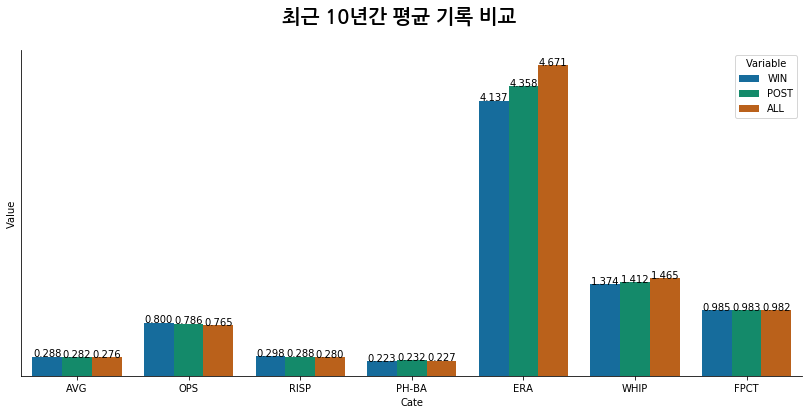

In [16]:
fig, ax = plt.subplots(figsize=(14, 6))
graph_df = feature_df.melt(id_vars='CATE').rename(columns=str.title)
sns.barplot(x='Cate', y='Value', hue='Variable', data=graph_df, ax=ax)
sns.despine(fig)

ax.grid(False)
ax.set_yticks([])

fig.suptitle('최근 10년간 평균 기록 비교', fontproperties=title_font)

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    label = '{:.3f}'.format(y_value)
    plt.annotate(label, (x_value, y_value), ha='center', fontsize=10)
    
plt.show()

대타 성공률을 제외한 모든 지표가 우승팀 평균이 전체 평균보다 상당히 좋은 수준을 가지고 있으므로,

우승팀 예측에 사용될 수 있음.

#### 데이터 정리와 타겟 변수 설정

In [17]:
# Cleaning Data for Classifier
# Change 'Y' to 1, 'N' to 0
df['WIN'] = df['WIN'].map(lambda x: 0 if x == 'N' else 1)
df['POST'] = df['POST'].map(lambda x: 0 if x == 'N' else 1)

In [18]:
# Set target data frames
win_y = df['WIN']
post_y = df['POST']

In [19]:
# Only pick the features with Ratio because it is middle of season
ratio_X = df[features]

In [20]:
ratio_X.head()

,AVG,OPS,RISP,PH-BA,ERA,WHIP,FPCT
0,0.262,0.714,0.268,0.221,4.55,1.50,0.982
1,0.281,0.805,0.284,0.210,4.62,1.38,0.982
2,0.288,0.813,0.315,0.202,4.82,1.43,0.981
3,0.272,0.774,0.265,0.247,3.94,1.36,0.982
4,0.244,0.690,0.263,0.172,5.43,1.57,0.984


In [21]:
# Split data set for train & test model
X_train, X_test, y_train, y_test = train_test_split(ratio_X, win_y, test_size=.2)

#### 로지스틱 회귀분석 모형을 사용해 초기 예측 모델 생성

분류 예측 모델 중 가장 기본이 되는 로지스틱 회귀분석 모형을 사용해,  
포스트시즌 진출 여부를 확인하는 예측 모델을 학습시켜보자

In [22]:
# Set pipeline with SS & Log_Regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs',
                                      random_state=27))
])

In [23]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=27,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

#### 테스트 데이터를 통한 모델 정확도 확인

In [24]:
test_preds = pipeline.predict(X_test)

In [25]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.50      0.67         2

    accuracy                           0.95        19
   macro avg       0.97      0.75      0.82        19
weighted avg       0.95      0.95      0.94        19



모델의 정확도는 95% 수준으로 비교적 정확한 편이라 할 수 있다.

#### 실제 데이터를 통한 확률 예측

In [26]:
# current(18/May) stat of KBO leagues 
# AVG(타율), OPS('출루율'+'장타율'), RISP('득점권타율'), PH-BA('대타타율'), 
# ERA('평균자책점'), WHIP('이닝당출루허용'), FPCT('수비율')

stat_20200518 = {
    'NC': [.281, .847, .309, .353, 3.26, 1.22, .988],
    'DOOSAN': [.337, .760, .348, 0.143, 6.24, 1.71, .978],
    'LG': [.288, .815, .304, .400, 5.05, 1.48, .990],
    'LOTTE': [.289, .818, .264, .111, 4.11, 1.34, .991],
    'KIWOOM': [.248, .725, .313, .308, 3.60, 1.26, .987],
    'KIA': [.261, .741, .245, .125, 5.31, 1.50, .977],
    'HANWHA':[.258, .654, .231, .111, 3.31, 1.24, .984],
    'KT': [.311, .857, .302, .286, 5.04, 1.47, .974],
    'SAMSUNG': [.228, .647, .287, .357, 5.02, 1.53, .970],
    'SK': [.230, .648, .194, .133, 5.68, 1.59, .988],    
}

In [27]:
# Print probabilties for each team
predicts = {}
for team, value in stat_20200518.items():
    proba = pipeline.predict_proba([value])[0][1]*100
    predicts[team] = proba
    print(f'{team} :  {proba:.4}%')

NC :  89.4%
DOOSAN :  4.562%
LG :  4.198%
LOTTE :  98.73%
KIWOOM :  29.43%
KIA :  0.03901%
HANWHA :  17.17%
KT :  0.2428%
SAMSUNG :  1.018e-05%
SK :  0.009951%


In [28]:
def draw_bar_chart(predicts, title='KBO 정규시즌 우승확률'):
    # Draw chart with Seaborn
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x=list(predicts.keys()), y=list(predicts.values()), ax=ax)
    sns.despine(fig)

    ax.grid(False)
    ax.set_yticks([])

    fig.suptitle(title, fontproperties=title_font)

    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        label = '{:.1f}%'.format(y_value)
        plt.annotate(label, (x_value, y_value), ha='center', fontsize=10)

    plt.show()

#### 우승 데이터는 케이스가 너무 적으므로 학습/테스트 데이터를 나누지 말고 전체 데이터로 학습을 시켜보자.

In [29]:
# Train model with whole dataset
pipeline.fit(ratio_X, win_y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=27,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [30]:
# Print probabilties for each team
predicts = {}
for team, value in stat_20200518.items():
    proba = pipeline.predict_proba([value])[0][1]*100
    predicts[team] = proba
    print(f'{team} :  {proba:.4}%')

NC :  94.4%
DOOSAN :  9.293%
LG :  5.187%
LOTTE :  98.93%
KIWOOM :  28.45%
KIA :  0.01301%
HANWHA :  8.169%
KT :  0.3721%
SAMSUNG :  2.156e-06%
SK :  0.001017%


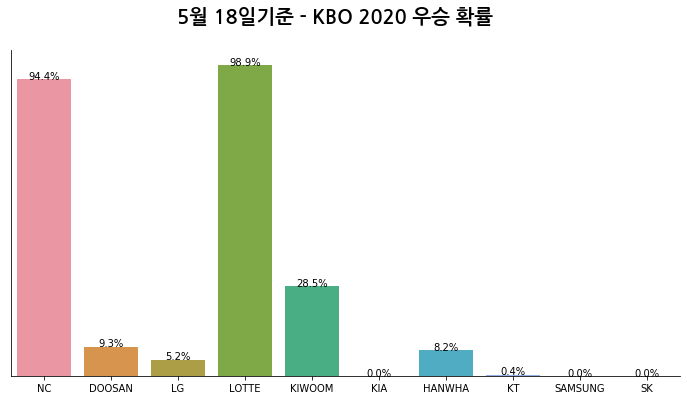

In [31]:
draw_bar_chart(predicts, '5월 18일기준 - KBO 2020 우승 확률')

### 포스트 시즌 진출 확률 예측

우승보다는 통계적으로 조금 더 유의미한 값을 구할 수 있는 포스트 시즌 예측 확률을 구해보자.

KBO리그는 단일리그로 상위 5위까지 포스트 시즌에 진출 하는 형태로 운영되고 있어,  
최근 10년간 데이터 셋 내에 보다 많은 진출/실패의 경우가 존재하고 있기 때문에,  
우승 예측보다는 비교적 정확한 예측 모델 생성이 가능하다

In [32]:
# Train & Test data
X_train, X_test, y_train, y_test = train_test_split(ratio_X, post_y, test_size=.2)

In [33]:
# Set pipeline with SS & Log_Regressor
pp_post_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs', 
                                      random_state=27))
])

In [34]:
# Train model
pp_post_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=27,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [35]:
# Predict and show model performance
test_preds = pp_post_lr.predict(X_test)

In [36]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.67      0.86      0.75         7

    accuracy                           0.79        19
   macro avg       0.78      0.80      0.78        19
weighted avg       0.81      0.79      0.79        19



최근 10년간 포스트시즌 진출 여부 데이터를 80:20 비율로 나누어  
80%의 데이터로 학습시키고, 20% 데이터로 검증을 실시해 본 결과,   
약 84% 수준의 정확도를 가지는 예측 모델이 학습되었다.

In [37]:
# Show odds for playoff
predicts = {}
for team, value in stat_20200518.items():
    proba = pp_post_lr.predict_proba([value])[0][1]*100
    predicts[team] = proba
    print(f'{team} :  {proba:.4}%')

NC :  100.0%
DOOSAN :  4.27%
LG :  99.59%
LOTTE :  98.91%
KIWOOM :  99.69%
KIA :  0.1038%
HANWHA :  25.43%
KT :  83.74%
SAMSUNG :  0.05785%
SK :  0.002343%


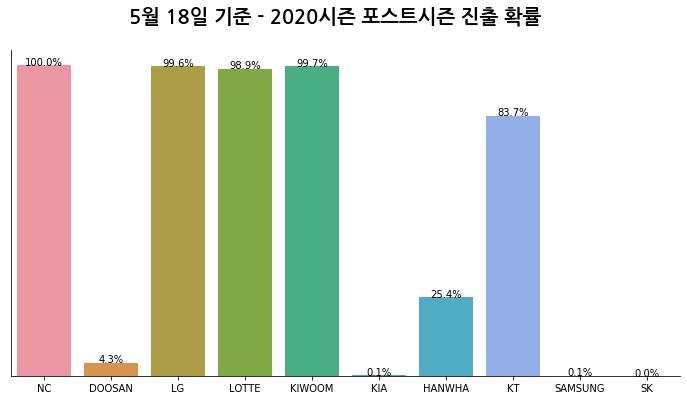

In [38]:
# 5/18 기준 포스트시즌 진출 확률
draw_bar_chart(predicts, title='5월 18일 기준 - 2020시즌 포스트시즌 진출 확률')

### <center>  - 2020/5/18 현재 순위표 - </center>

| 순위 	| 팀명 	| 경기 	| 승 	| 패 	| 무 	| 승률  	| 게임차 	| 타율  	| OPS   	| 득점권타율 	| 대타타율 	| 평균자책 	| WHIP  	| 수비율 	| POST 확율 	|
|------	|------	|------	|----	|----	|----	|-------	|--------	|-------	|-------	|------------	|----------	|----------	|-------	|--------	|-----------	|
| 1    	| NC   	| 11   	| 10 	| 1  	| 0  	| 0.909 	| 0      	| 0.281 	| 0.847 	| 0.309      	| 0.353    	| 3.260    	| 1.220 	| 0.988  	| 100%      	|
| 2    	| 두산 	| 11   	| 7  	| 4  	| 0  	| 0.636 	| 3      	| 0.337 	| 0.760 	| 0.348      	| 0.143    	| 6.240    	| 1.710 	| 0.978  	| 4.27%     	|
| 2    	| LG   	| 11   	| 7  	| 4  	| 0  	| 0.636 	| 3      	| 0.288 	| 0.815 	| 0.304      	| 0.400    	| 5.050    	| 1.480 	| 0.990  	| 99.59%    	|
| 2    	| 롯데 	| 11   	| 7  	| 4  	| 0  	| 0.636 	| 3      	| 0.289 	| 0.818 	| 0.264      	| 0.111    	| 4.110    	| 1.340 	| 0.991  	| 98.91%    	|
| 5    	| 키움 	| 12   	| 7  	| 5  	| 0  	| 0.583 	| 3.5    	| 0.248 	| 0.725 	| 0.313      	| 0.308    	| 3.600    	| 1.260 	| 0.987  	| 99.69%    	|
| 6    	| KIA  	| 12   	| 5  	| 7  	| 0  	| 0.417 	| 5.5    	| 0.261 	| 0.741 	| 0.245      	| 0.125    	| 5.310    	| 1.500 	| 0.977  	| 0.1%      	|
| 6    	| 한화 	| 12   	| 5  	| 7  	| 0  	| 0.417 	| 5.5    	| 0.258 	| 0.654 	| 0.231      	| 0.111    	| 3.310    	| 1.240 	| 0.984  	| 25.43%    	|
| 8    	| KT   	| 11   	| 4  	| 7  	| 0  	| 0.364 	| 6      	| 0.311 	| 0.857 	| 0.302      	| 0.286    	| 5.040    	| 1.470 	| 0.974  	| 83.74%    	|
| 9    	| 삼성 	| 12   	| 4  	| 8  	| 0  	| 0.333 	| 6.5    	| 0.228 	| 0.647 	| 0.287      	| 0.357    	| 5.020    	| 1.530 	| 0.970  	| 0.05%     	|
| 10   	| SK   	| 11   	| 1  	| 10 	| 0  	| 0.091 	| 9      	| 0.230 	| 0.648 	| 0.194      	| 0.133    	| 5.680    	| 1.590 	| 0.988  	| 0.002%    	|


### 5/18 결론

시즌 초반이지만, NC, LG, 키움, 롯데 등이 전형적인 강팀이 보여주는 타격/투수력 지표를 보여주고 있어,  
예측 모델 상으로는 아주 높은 포스트시즌 진출 확률을 나타내고 있다.  
상위권인 두산은 높은 팀평균자책점 때문에 2위임에도 불구하고 아주 낮은 포스트 시즌 확률을 보여주고 있고,  
패가 많은 KT는 상대적으로 투타 균형을 보여주고 있는 관계로 비교적 높은 포스트 시즌 확률을 가지고 있다.


